In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading Data

In [36]:
uber = pd.read_csv('Uber Request Data.csv')

## Analyze the data structure of the file

In [37]:
uber.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB


In [38]:
uber.rename(columns={'Pickup point':'Pickuppoint'},inplace=True)

## Glimpse of data

In [39]:
uber.head()

,Request id,Pickuppoint,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


## Identify categorial variables

In [40]:
print(uber['Pickuppoint'].unique())
uber['Status'].unique()

['Airport' 'City']


array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

##### Pickup point --> data contains only  Airport/City


### Coversion object type to datetime type

In [41]:
uber['Request timestamp']=pd.to_datetime(uber['Request timestamp'],dayfirst = True)
uber['Drop timestamp']=pd.to_datetime(uber['Drop timestamp'],dayfirst = True)

### Deriving new variables: For further analysis to point out exact time slots  
Hourofday, dayofweek,partofday

In [42]:
uber['partofday'] = pd.cut(uber['Request timestamp'].dt.hour,[-1,4,9,12,16,21,23],labels=['latenight','early morning','Morning rush','afternoon','evening','night'])

In [43]:
uber['Hourofday']= uber['Request timestamp'].dt.hour

In [44]:
uber['dayofweek']=uber['Request timestamp'].dt.day_name()

In [45]:
uber.head()


,Request id,Pickuppoint,Driver id,Status,Request timestamp,Drop timestamp,partofday,Hourofday,dayofweek
0,619,Airport,1.0,Trip Completed,2016-07-11 11:51:00,2016-07-11 13:00:00,Morning rush,11,Monday
1,867,Airport,1.0,Trip Completed,2016-07-11 17:57:00,2016-07-11 18:47:00,evening,17,Monday
2,1807,City,1.0,Trip Completed,2016-07-12 09:17:00,2016-07-12 09:58:00,early morning,9,Tuesday
3,2532,Airport,1.0,Trip Completed,2016-07-12 21:08:00,2016-07-12 22:03:00,evening,21,Tuesday
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,early morning,8,Wednesday


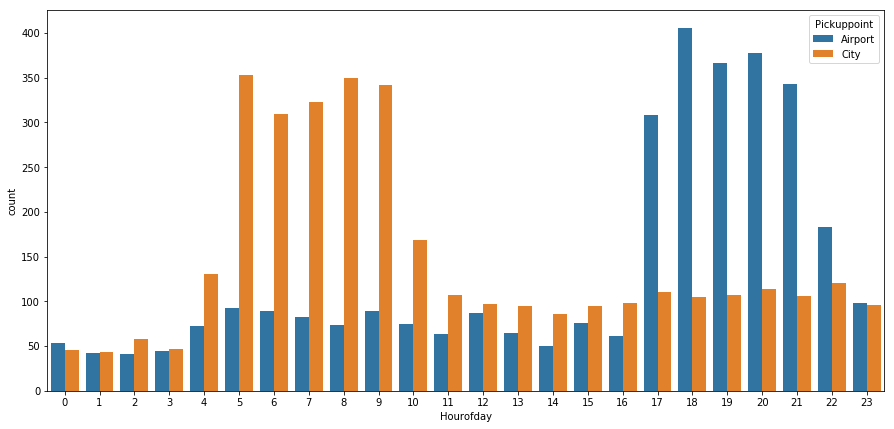

In [165]:
plt.figure(figsize=(15,7))
ax = sns.countplot(x= 'Hourofday',hue='Pickuppoint',data=uber)

#### Huge spike in requests during evening,early morning
let see how much of the demand is met

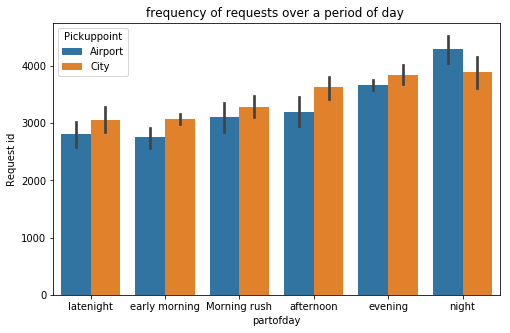

In [166]:
plt.figure(figsize=(8,5))
plt.title('frequency of requests over a period of day ')
ax = sns.barplot(x ='partofday',y='Request id',hue='Pickuppoint',data=uber)

## Lets analyze the demand pattern over weekdays

In [146]:
uber1= uber.loc[uber['Pickuppoint'].isin(['Airport'])]
uber2= uber.loc[uber['Pickuppoint'].isin(['City'])]

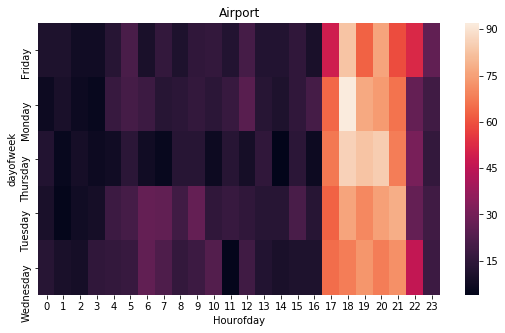

In [168]:

plt.figure(figsize=(9,5))
plt.title("Airport")
g=sns.heatmap(uber1.set_index('dayofweek').pivot_table(columns='Hourofday',values='Request id',index='dayofweek',aggfunc=np.size))


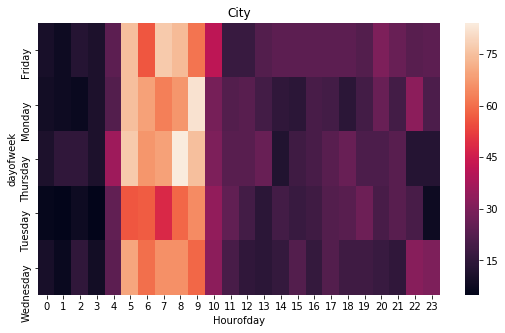

In [169]:
plt.figure(figsize=(9,5))
plt.title("City")
g=sns.heatmap(uber2.set_index('dayofweek').pivot_table(columns='Hourofday',values='Request id',index='dayofweek',aggfunc=np.size))


#### Observation: Heat maps to Airport/City suggests that Demand is almost same 
through out all the weekdays(for the given data set)

###### Frequency of requests for different status

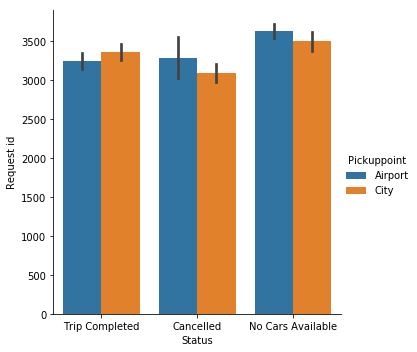

In [48]:
f,axes =figsize=(5,3)
g=sns.catplot(x= 'Status',y= 'Request id',hue = 'Pickuppoint',data=uber,kind='bar')

#### Observation 1: From Airport  'Cancelled', 'No Cars Available' requests more when compared to city,
looks like there is some problem with Airport demand

#### Identifying the Time slots where the most problematic requests resides

Text(0.5,1,'Airport')

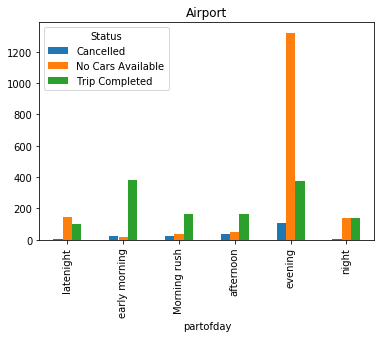

In [174]:

uber1.set_index('partofday').pivot_table(columns='Status',values='Request id',index='partofday',aggfunc=np.size).plot.bar()
plt.title("Airport")

In [88]:
uber1.set_index('partofday').pivot_table(columns='Status',values='Request id',index='partofday',aggfunc=np.size)

Status,Cancelled,No Cars Available,Trip Completed
partofday,,,
latenight,2,148,103
early morning,23,21,382
Morning rush,24,37,165
afternoon,40,50,162
evening,106,1321,373
night,3,136,142


#### Observation: At Airport during evening,latenight,night more No Cars Available than cancelled

Text(0.5,1,'City')

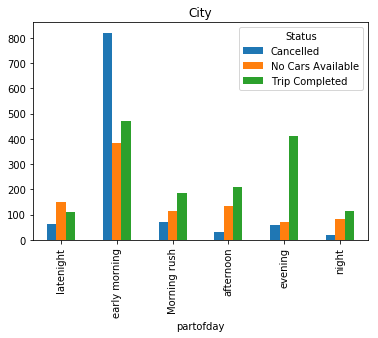

In [90]:
uber2.set_index('partofday').pivot_table(columns='Status',values='Request id',index='partofday',aggfunc=np.size).plot.bar()
plt.title("City")

In [93]:
uber2.set_index('partofday').pivot_table(columns='Status',values='Request id',index='partofday',aggfunc=np.size)

Status,Cancelled,No Cars Available,Trip Completed
partofday,,,
latenight,63,151,111
early morning,820,385,472
Morning rush,72,113,187
afternoon,32,134,208
evening,60,71,411
night,19,83,115


#### Observation: At City during Early morning more cancelled requests;Early morning,latenight, afternoon no cars available

## GAP Analysis

##### Gap = Demand(All Requests) - Supply(Trip Completed) == (no cars available,cancelled requests)

In [63]:
uber['gap'] = np.where(uber['Status'] == 'Trip Completed','Supply','Demand not met')

#### Analyzing Gap in a particular Time Slots

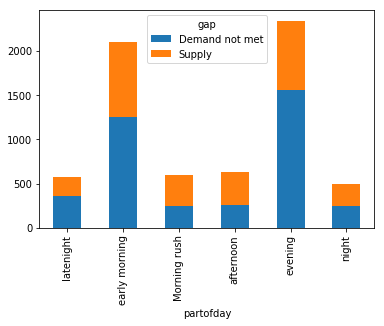

In [95]:
g=uber.set_index('partofday').pivot_table(index='partofday',values='Request id',columns='gap',aggfunc=np.size).plot.bar(stacked=True)

In [96]:
uber.set_index('partofday').pivot_table(index='partofday',values='Request id',columns='gap',aggfunc=np.size)

gap,Demand not met,Supply
partofday,,
latenight,364,214
early morning,1249,854
Morning rush,246,352
afternoon,256,370
evening,1558,784
night,241,257


##### Observation: The highest gap is at evening,Early morning and then at latenight

In [97]:
uber_final= uber.loc[uber['partofday'].isin(['evening','early morning','latenight'])]


In [98]:
uber_final=uber_final[uber_final['gap'] == 'Demand not met']

In [99]:
uber_final = uber_final.set_index('Pickuppoint').pivot_table(index='Pickuppoint',values='Request id',columns='partofday',aggfunc=np.size)

In [100]:
uber_final.head()

partofday,early morning,evening,latenight
Pickuppoint,,,
Airport,150,44,1427
City,214,1205,131


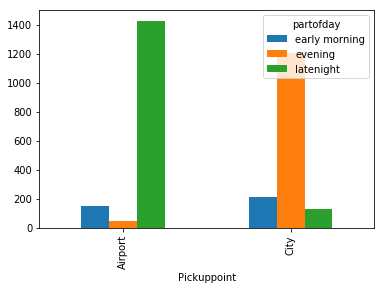

In [101]:

x= uber_final.plot.bar()

#### Observation: At Airport, huge gap is at latenight where as evening demand is not met at City.

####  where as Early morning demand is not met at Airport/city